# COMP47590: Advanced Machine Learning
# Assignment 1: Building Stacked Ensembles

Name(s): Vidushi Jain

Student Number(s):18200009

## Import Packages Etc

In [1]:
from IPython.display import display, HTML, Image

from TAS_Python_Utilities import data_viz
from TAS_Python_Utilities import data_viz_target
from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial import distance
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score
import itertools

%matplotlib inline
#%qtconsole

## Define StackedEnsembleClassifier

Utility function to create classifer objects based on a name

In [2]:
def create_classifier(classifier_type, tree_min_samples_split = 20):

    if classifier_type == "svm":
        c = svm.SVC(probability=True)

    elif classifier_type == "logreg":
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)

    elif classifier_type == "knn":
        c = neighbors.KNeighborsClassifier()

    elif classifier_type == "tree":
        c = tree.DecisionTreeClassifier(min_samples_split = tree_min_samples_split)

    elif classifier_type == "randomforest":
        c = ensemble.RandomForestClassifier()
        
    else:
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
    
    return c

StackedEnsembleClassifier class.

In [133]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_train)

            
            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]                
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Test the StackedEnsembleClassifier

Perform a simple test using the StackedEnsembleClassifier on the Iris dataset

In [134]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = StackedEnsembleClassifier()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      0.96      0.98        50
          2       0.96      1.00      0.98        50

avg / total       0.99      0.99      0.99       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,0,50,50
All,50,48,52,150


Perform a cross validation experiment

In [135]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         0.93333333 0.93333333 0.93333333
 0.93333333 1.         1.         1.        ]
0.9666666666666666  +/-  0.033333333333333326


## Task 1: Design the StackedEnsembleHoldOut Class

To Design StackedEnsembleHoldOut Class, we have modified the fit method. In this we first split the dataset into training and test dataset. We use <b>training</b> dataset to train all the base models and then use <b>test</b> dataset to generate the training data for the stack layer. Then we train the stack layer model with this newly generated training data. 

In [136]:
class StackedEnsembleHoldOut(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        #Divide the dataset into training and test set. Training set is used to train the base models and test set \
        #is used to generate the training data for stack layer
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, \
                                           train_size = 0.7)
        
        
        # Set up empty arrays to hold stack layer training data. Since we are using hold out dataset for testing, so 
        #we will set y_stack_train as y_test. 
        
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_test
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the test set
            y_pred = classifier.predict_proba(X_test)

            # Append the predictions at the stack layer training set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]                
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)      
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

### Test the StackedEnsembleHoldOutClassifier

Perform a simple test using the StackedEnsembleHoldOutClassifier on the Iris dataset

In [137]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = StackedEnsembleHoldOut()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      0.96      0.98        50
          2       0.96      1.00      0.98        50

avg / total       0.99      0.99      0.99       150

Confusion Matrix


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,0,50,50
All,50,48,52,150


## Task 2: Design the StackedEnsembleKFold Class

To Design StackedEnsembleKFold Class, we have modified the fit method. In this we first split the training data into K-Folds using StratifiedKFold method. All the base models are fitted on the K-1 parts and prediction are made for the Kth part. We repeat this process for each fold of the training data. Predictions which are made on the Kth part are concatenated and given as the training data for the stack layer. At the end we train the base classifiers on the whole dataset. 

In [138]:
class StackedEnsembleKFold(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    base_estimators: list 
        A list of the classifiers in the ase layer of the ensemble. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    classifier_duplicates: int, optional (default = 1)
        How many instances of each classifier type listed in base_estimators is included in the ensemble
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 1, \
                 stack_layer_classifier_type = "logreg", training_folds=4):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type
        self.training_folds = training_folds

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """    
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        
        # we divide the dataset into k-folds using Stratified KFold method
        stratified_KFold = StratifiedKFold(n_splits=self.training_folds)
        stratified_KFold.get_n_splits(X, y)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        #Creating an empty array to store the target value of the instances in the fold which we will use for testing
        self.y_stack_train = np.array([]) 
        
        
        #We split the training data into K-Folds. Base classifiers are trained on K-1 parts and prediction is 
        #made on the kth path. We do this process for each part of the training data. This reduces the risk of overfitting
        
       # Iterate through the K-1 folds to train the model and then we will use the test split (Kth fold)to generate training data for the stack layer
        for train_index, test_index in stratified_KFold.split(X, y):
            
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
    
            self.y_stack_train = np.r_[self.y_stack_train, y_test]
            
            X_stack_train_fold = None
            
            for classifier in self.classifiers_:
                # Extract a bootstrap sample
                X_train_samp, y_train_samp = resample(X_train, y_train, replace=True) 
                
                # Train a base classifier
                classifier.fit(X_train_samp, y_train_samp)
                
                # Make predictions for all instances in the test set
                y_pred = classifier.predict_proba(X_test)
                try:
                    X_stack_train_fold = np.c_[X_stack_train_fold, y_pred]
                except ValueError:
                    X_stack_train_fold = y_pred    
                
            try:
                self.X_stack_train = np.r_[self.X_stack_train, X_stack_train_fold]
            except ValueError:
                self.X_stack_train = X_stack_train_fold    
            
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
        
        
        # Re-train the base classifiers in the ensemble using the full dataset            
        
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                
                # Extract a bootstrap sample
                X_train_samp, y_train_samp = resample(X, y, replace=True)
                # Train a base classifier
                c.fit(X_train_samp, y_train_samp)
                self.classifiers_.append(c)
        
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)


### Test the StackedEnsembleKFoldClassifier

Perform a simple test using the StackedEnsembleKFoldClassifier on the Iris dataset

In [139]:
from sklearn.datasets import load_iris
iris = load_iris()
clf = StackedEnsembleKFold()
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      0.96      0.98        50
          2       0.96      1.00      0.98        50

avg / total       0.99      0.99      0.99       150

Confusion Matrix


Predicted,0.0,1.0,2.0,All
True,,,,
0,50,0,0,50
1,0,48,2,50
2,0,0,50,50
All,50,48,52,150


Perform a cross validation experiment

In [140]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         1.         0.93333333 1.
 0.93333333 1.         1.         1.        ]
0.9800000000000001  +/-  0.030550504633038926


## Task 3: Compare the Performance of Different Stack Layer Approaches

To Compare the performance of different stack layer approaches, we have taken 24 base classifiers using a mixture of decision trees, support vector machines and logistic regression models. For this I have set the <b>base_estimator_types = ["svm", "logreg", "tree"]</b> and <b>base_estimator_duplicates = 8 </b>. At stack layer, in one scenario we are using <b>logistic regression model</b> and in another we are using <b>decision trees</b>.


Setup- Take only a sample of the dataset for fast testing

In [3]:
data_sampling_rate = 0.05

Setup the number of folds for all grid searches (should be 5 - 10)

In [4]:
cv_folds = 5

Set up a dictionary to store simple model perofrmance comparions

In [5]:
model_test_accuracy_comparisons = dict()
model_valid_accuracy_comparisons = dict()
model_test_f1_comparisons = dict()
model_valid_f1_comparisons = dict()
model_tuned_params_list = dict()

### Load & Partition Data

In [6]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
53566,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19965,2,0,0,0,0,0,0,60,173,184,...,158,143,121,107,38,0,0,0,0,0
51904,0,0,0,0,0,0,0,0,0,0,...,133,89,0,0,0,0,0,0,0,0
12743,2,0,0,2,0,1,0,0,0,0,...,184,116,84,89,29,0,0,0,0,0
59505,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Partitioning and Pre-processing Data

In [7]:
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])

In [8]:
X = X/255

Dividing the dataset into train, test and validation set

In [9]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### StackedEnsembleClassifier with Logistic regression model at Stack Layer


Train the Stacked Ensemble Classifier model 

In [148]:
stackedEnsembleModel = StackedEnsembleClassifier(base_estimator_types = ["svm", "logreg", "tree"],\
                                                 base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg")
stackedEnsembleModel.fit(X_train, y_train)

StackedEnsembleClassifier(base_estimator_duplicates=8,
             base_estimator_types=['svm', 'logreg', 'tree'],
             stack_layer_classifier_type='logreg')

Assess the performance of the ensemble tree on the <b>training set</b>

In [149]:
y_pred = stackedEnsembleModel.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

print("Confusion Matrix")
display(pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.9873333333333333
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       121
          1       1.00      1.00      1.00       142
          2       0.98      0.96      0.97       169
          3       0.99      1.00      1.00       147
          4       0.96      0.98      0.97       147
          5       1.00      1.00      1.00       142
          6       0.98      0.96      0.97       167
          7       0.99      1.00      1.00       149
          8       1.00      1.00      1.00       158
          9       1.00      0.99      1.00       158

avg / total       0.99      0.99      0.99      1500

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,118,0,1,1,0,0,1,0,0,0,121
1,0,142,0,0,0,0,0,0,0,0,142
2,1,0,163,0,4,0,1,0,0,0,169
3,0,0,0,147,0,0,0,0,0,0,147
4,0,0,1,0,144,0,2,0,0,0,147
5,0,0,0,0,0,142,0,0,0,0,142
6,2,0,2,0,2,0,161,0,0,0,167
7,0,0,0,0,0,0,0,149,0,0,149
8,0,0,0,0,0,0,0,0,158,0,158


Assess the performance of the ensemble on the <b>validation dataset</b>

In [150]:
y_pred = stackedEnsembleModel.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["StackedEnsembleClassifier LogisticRegression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))
report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["StackedEnsembleClassifier LogisticRegression"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.81
             precision    recall  f1-score   support

          0       0.83      0.87      0.85        52
          1       0.97      0.97      0.97        58
          2       0.73      0.71      0.72        69
          3       0.79      0.90      0.84        63
          4       0.72      0.62      0.67        63
          5       0.85      0.87      0.86        54
          6       0.54      0.54      0.54        56
          7       0.84      0.85      0.84        60
          8       0.93      0.92      0.92        73
          9       0.88      0.87      0.87        52

avg / total       0.81      0.81      0.81       600

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,45,0,1,2,0,0,4,0,0,0,52
1,0,56,1,0,0,0,0,0,1,0,58
2,0,0,49,1,12,0,7,0,0,0,69
3,1,2,1,57,2,0,0,0,0,0,63
4,0,0,9,3,39,0,12,0,0,0,63
5,0,0,0,0,0,47,0,4,1,2,54
6,8,0,6,8,1,0,30,0,3,0,56
7,0,0,0,0,0,5,0,51,0,4,60
8,0,0,0,1,0,1,3,1,67,0,73


Assess the performance of the tree on the <b>test dataset</b>

In [151]:
# Make a set of predictions for the test data
y_pred = stackedEnsembleModel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifier LogisticRegression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["StackedEnsembleClassifier LogisticRegression"] = report.split('\n')[-2].split('      ')[3]
# Print confusion matrix
# print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8044444444444444
             precision    recall  f1-score   support

          0       0.75      0.72      0.73        90
          1       0.98      0.95      0.97       102
          2       0.68      0.72      0.70        87
          3       0.75      0.89      0.81        76
          4       0.70      0.64      0.67        81
          5       0.93      0.88      0.90        86
          6       0.54      0.48      0.51       104
          7       0.90      0.88      0.89        98
          8       0.92      0.95      0.93        92
          9       0.87      0.95      0.91        84

avg / total       0.80      0.80      0.80       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,65,0,3,9,1,1,10,0,1,0,90
1,0,97,1,2,0,0,2,0,0,0,102
2,2,0,63,0,7,0,14,0,1,0,87
3,1,2,2,68,2,0,1,0,0,0,76
4,1,0,7,7,52,0,14,0,0,0,81
5,0,0,0,0,0,76,0,6,0,4,86
6,17,0,15,4,12,0,50,0,6,0,104
7,0,0,0,0,0,4,0,86,0,8,98
8,1,0,1,1,0,0,1,1,87,0,92


Perfrom a cross validation experiment to evaluate the performance of the StackedEnsembleClassifier

In [152]:
scores = cross_val_score(stackedEnsembleModel,X_train_plus_valid, y_train_plus_valid, cv=cv_folds, \
                         n_jobs=-1, verbose = 2)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 2.1min
[CV] ................................................. , total= 2.1min
[CV] ................................................. , total= 2.1min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.1min remaining:  1.4min


[CV] ................................................. , total= 2.1min
[CV] ................................................. , total= 2.1min
[0.81560284 0.78622328 0.80047506 0.80143541 0.8057554 ]
0.8018983953107224  +/-  0.00949355275689598


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


### StackedEnsembleClassifierHoldOut with Logistic regression model at Stack Layer

In [153]:
stackedEnsembleHoldOutModel = StackedEnsembleHoldOut(base_estimator_types = ["svm", "logreg", "tree"], \
                                                     base_estimator_duplicates = 8,\
                                                     stack_layer_classifier_type = "logreg")
stackedEnsembleHoldOutModel.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


StackedEnsembleHoldOut(base_estimator_duplicates=8,
            base_estimator_types=['svm', 'logreg', 'tree'],
            stack_layer_classifier_type='logreg')

Assess the performance of the ensemble tree on the training set

In [154]:
y_pred = stackedEnsembleHoldOutModel.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.9053333333333333
             precision    recall  f1-score   support

          0       0.91      0.75      0.82       121
          1       0.99      0.97      0.98       142
          2       0.88      0.84      0.86       169
          3       0.84      0.95      0.89       147
          4       0.84      0.85      0.85       147
          5       0.95      0.97      0.96       142
          6       0.77      0.81      0.79       167
          7       0.96      0.95      0.96       149
          8       0.98      0.99      0.98       158
          9       0.96      0.96      0.96       158

avg / total       0.91      0.91      0.91      1500

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,91,0,3,11,0,0,16,0,0,0,121
1,0,138,0,4,0,0,0,0,0,0,142
2,2,0,142,3,11,0,11,0,0,0,169
3,1,2,2,139,1,0,2,0,0,0,147
4,0,0,5,4,125,0,12,0,1,0,147
5,0,0,0,0,0,138,0,2,0,2,142
6,6,0,9,3,11,0,136,0,2,0,167
7,0,0,0,0,0,3,0,142,0,4,149
8,0,0,0,1,0,0,0,1,156,0,158


Assess the performance of the ensemble on the <b>validation dataset</b>

In [155]:
y_pred = stackedEnsembleHoldOutModel.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["StackedEnsembleHoldOutClassifier LogisticRegression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))
report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["StackedEnsembleHoldOutClassifier LogisticRegression"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8
             precision    recall  f1-score   support

          0       0.81      0.73      0.77        52
          1       1.00      0.97      0.98        58
          2       0.81      0.68      0.74        69
          3       0.74      0.90      0.81        63
          4       0.72      0.65      0.68        63
          5       0.84      0.85      0.84        54
          6       0.49      0.59      0.54        56
          7       0.82      0.92      0.87        60
          8       0.93      0.89      0.91        73
          9       0.91      0.81      0.86        52

avg / total       0.81      0.80      0.80       600

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,38,0,2,7,0,0,5,0,0,0,52
1,0,56,0,0,0,0,1,0,1,0,58
2,0,0,47,0,11,0,11,0,0,0,69
3,2,0,1,57,2,0,1,0,0,0,63
4,0,0,3,6,41,0,13,0,0,0,63
5,0,0,0,0,0,46,0,5,1,2,54
6,7,0,5,6,2,0,33,0,3,0,56
7,0,0,0,0,0,3,0,55,0,2,60
8,0,0,0,1,1,1,3,2,65,0,73


Assess the performance of the tree on the <b>test dataset</b>

In [156]:
# Make a set of predictions for the test data
y_pred = stackedEnsembleHoldOutModel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleHoldOutClassifier LogisticRegression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["StackedEnsembleHoldOutClassifier LogisticRegression"] = report.split('\n')[-2].split('      ')[3]

# Print confusion matrix
# print(metrics.confusion_matrix(y_test, y_pred))

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8033333333333333
             precision    recall  f1-score   support

          0       0.81      0.67      0.73        90
          1       0.99      0.96      0.98       102
          2       0.71      0.69      0.70        87
          3       0.72      0.91      0.80        76
          4       0.69      0.72      0.70        81
          5       0.89      0.92      0.90        86
          6       0.52      0.47      0.49       104
          7       0.91      0.88      0.90        98
          8       0.92      0.98      0.95        92
          9       0.86      0.88      0.87        84

avg / total       0.80      0.80      0.80       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,60,0,1,12,0,1,15,0,1,0,90
1,0,98,1,2,0,0,1,0,0,0,102
2,0,0,60,0,12,0,14,0,1,0,87
3,2,1,2,69,0,0,2,0,0,0,76
4,0,0,3,6,58,0,13,0,1,0,81
5,0,0,0,0,0,79,0,4,0,3,86
6,12,0,18,6,14,0,49,0,5,0,104
7,0,0,0,0,0,3,0,86,0,9,98
8,0,0,0,1,0,0,1,0,90,0,92


Perfrom a cross validation experiment to evaluate the performance of the StackedEnsembleHoldOutClassifier

In [157]:
scores = cross_val_score(stackedEnsembleHoldOutModel,X_train_plus_valid, y_train_plus_valid, cv=cv_folds, \
                         n_jobs=-1, verbose = 2)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[CV]  ................................................................
[CV]  ................................................................


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[CV]  ................................................................


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[CV]  ................................................................


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[CV]  ................................................................


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.1min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.1min remaining:   42.3s


[CV] ................................................. , total= 1.1min
[0.79669031 0.79572447 0.78384798 0.80382775 0.79376499]
0.7947710986180379  +/-  0.006433381437846476


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


### StackedEnsembleClassifierkFold  with Logistic regression model at Stack Layer

In [158]:
stackedEnsembleKFoldModel = StackedEnsembleKFold(base_estimator_types = ["svm", "logreg", "tree"], \
                                                 base_estimator_duplicates = 8, \
                                                 stack_layer_classifier_type = "logreg")
stackedEnsembleKFoldModel.fit(X_train, y_train)

StackedEnsembleKFold(base_estimator_duplicates=8,
           base_estimator_types=['svm', 'logreg', 'tree'],
           stack_layer_classifier_type='logreg', training_folds=4)

Assess the performance of the ensemble tree on the <b>training set</b>

In [159]:
y_pred = stackedEnsembleKFoldModel.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.9166666666666666
             precision    recall  f1-score   support

          0       0.82      0.86      0.84       121
          1       0.99      0.97      0.98       142
          2       0.89      0.92      0.90       169
          3       0.86      0.93      0.89       147
          4       0.88      0.84      0.86       147
          5       0.97      0.99      0.98       142
          6       0.83      0.75      0.79       167
          7       0.98      0.95      0.97       149
          8       0.97      0.98      0.98       158
          9       0.96      0.97      0.97       158

avg / total       0.92      0.92      0.92      1500

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,104,0,1,8,1,0,7,0,0,0,121
1,0,138,0,4,0,0,0,0,0,0,142
2,3,0,156,1,4,0,5,0,0,0,169
3,3,1,1,137,4,0,1,0,0,0,147
4,0,0,7,5,123,0,11,0,1,0,147
5,0,0,0,0,0,141,0,0,0,1,142
6,17,0,11,4,7,0,125,0,3,0,167
7,0,0,0,0,0,2,0,142,0,5,149
8,0,0,0,1,0,0,1,1,155,0,158


Assess the performance of the ensemble on the <b>validation dataset</b>

In [160]:
y_pred = stackedEnsembleKFoldModel.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["StackedEnsembleKFoldClassifier LogisticRegression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["StackedEnsembleKFoldClassifier LogisticRegression"] = report.split('\n')[-2].split('      ')[3]

print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8116666666666666
             precision    recall  f1-score   support

          0       0.82      0.81      0.82        52
          1       1.00      0.97      0.98        58
          2       0.77      0.80      0.79        69
          3       0.72      0.89      0.79        63
          4       0.73      0.59      0.65        63
          5       0.85      0.87      0.86        54
          6       0.57      0.55      0.56        56
          7       0.84      0.85      0.84        60
          8       0.93      0.92      0.92        73
          9       0.88      0.87      0.87        52

avg / total       0.81      0.81      0.81       600

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,42,0,0,6,0,0,4,0,0,0,52
1,0,56,1,0,0,0,0,0,1,0,58
2,1,0,55,2,8,0,3,0,0,0,69
3,1,0,1,56,4,0,1,0,0,0,63
4,0,0,8,5,37,0,13,0,0,0,63
5,0,0,0,0,0,47,0,4,1,2,54
6,7,0,6,8,1,0,31,0,3,0,56
7,0,0,0,0,0,5,0,51,0,4,60
8,0,0,0,1,1,1,2,1,67,0,73


Assess the performance of the tree on the <b>test dataset</b>

In [161]:
# Make a set of predictions for the test data
y_pred = stackedEnsembleKFoldModel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleKFoldClassifier LogisticRegression"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["StackedEnsembleKFoldClassifier LogisticRegression"] = report.split('\n')[-2].split('      ')[3]

# Print nicer confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7977777777777778
             precision    recall  f1-score   support

          0       0.73      0.73      0.73        90
          1       0.98      0.95      0.97       102
          2       0.66      0.72      0.69        87
          3       0.72      0.89      0.80        76
          4       0.71      0.63      0.67        81
          5       0.91      0.92      0.91        86
          6       0.55      0.43      0.48       104
          7       0.91      0.85      0.88        98
          8       0.92      0.96      0.94        92
          9       0.86      0.93      0.89        84

avg / total       0.79      0.80      0.79       900

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,66,0,2,14,0,1,6,0,1,0,90
1,0,97,2,2,0,0,1,0,0,0,102
2,1,0,63,0,10,0,12,0,1,0,87
3,5,0,1,68,0,0,2,0,0,0,76
4,0,2,7,7,51,0,14,0,0,0,81
5,0,0,0,0,0,79,0,4,0,3,86
6,19,0,20,3,11,0,45,0,6,0,104
7,0,0,0,0,0,5,0,83,0,10,98
8,0,0,1,1,0,0,2,0,88,0,92


Perfrom a cross validation experiment to evaluate the performance of the StackedEnsembleKFoldClassifier

In [162]:
scores = cross_val_score(stackedEnsembleKFoldModel,X_train_plus_valid, y_train_plus_valid, cv=cv_folds, \
                         n_jobs=-1, verbose = 2)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 6.2min
[CV] ................................................. , total= 6.4min
[CV] ................................................. , total= 6.4min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  6.4min remaining:  4.3min


[CV] ................................................. , total= 6.4min
[CV] ................................................. , total= 6.5min
[0.8179669  0.78384798 0.7719715  0.78229665 0.79376499]
0.7899696038470523  +/-  0.015611111755939475


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.5min finished


### StackedEnsembleClassifier with Decision Tree model at Stack Layer

In [163]:
StackedEnsembleClassifierTree = StackedEnsembleClassifier(base_estimator_types = ["svm", "logreg", "tree"], \
                                                          base_estimator_duplicates = 8,\
                                                          stack_layer_classifier_type = "tree")
StackedEnsembleClassifierTree.fit(X_train, y_train)

StackedEnsembleClassifier(base_estimator_duplicates=8,
             base_estimator_types=['svm', 'logreg', 'tree'],
             stack_layer_classifier_type='tree')

Assess the performance of the ensemble tree on the <b>training set</b>

In [164]:
y_pred = StackedEnsembleClassifierTree.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.9486666666666667
             precision    recall  f1-score   support

          0       0.96      0.94      0.95       121
          1       1.00      1.00      1.00       142
          2       0.73      0.98      0.84       169
          3       1.00      0.89      0.94       147
          4       0.94      0.91      0.93       147
          5       1.00      0.99      1.00       142
          6       0.99      0.81      0.89       167
          7       0.99      0.99      0.99       149
          8       1.00      0.97      0.99       158
          9       1.00      0.99      1.00       158

avg / total       0.96      0.95      0.95      1500

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,114,0,4,0,1,0,2,0,0,0,121
1,0,142,0,0,0,0,0,0,0,0,142
2,1,0,166,0,2,0,0,0,0,0,169
3,2,0,13,131,1,0,0,0,0,0,147
4,0,0,13,0,134,0,0,0,0,0,147
5,0,0,0,0,0,141,0,1,0,0,142
6,2,0,25,0,4,0,136,0,0,0,167
7,0,0,1,0,0,0,0,148,0,0,149
8,0,0,4,0,0,0,0,0,154,0,158


Assess the performance of the ensemble tree on the <b>Validation set</b>

In [165]:
y_pred = StackedEnsembleClassifierTree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["StackedEnsembleClassifier DecisionTree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["StackedEnsembleClassifier DecisionTree"] = report.split('\n')[-2].split('      ')[3]


# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.7766666666666666
             precision    recall  f1-score   support

          0       0.80      0.79      0.80        52
          1       1.00      0.95      0.97        58
          2       0.51      0.68      0.58        69
          3       0.85      0.81      0.83        63
          4       0.67      0.63      0.65        63
          5       0.85      0.87      0.86        54
          6       0.53      0.45      0.49        56
          7       0.82      0.88      0.85        60
          8       0.92      0.84      0.88        73
          9       0.94      0.88      0.91        52

avg / total       0.79      0.78      0.78       600

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,41,0,4,0,1,0,6,0,0,0,52
1,0,55,2,0,0,0,0,0,1,0,58
2,0,0,47,1,12,1,8,0,0,0,69
3,3,0,5,51,3,0,1,0,0,0,63
4,0,0,13,4,40,0,6,0,0,0,63
5,0,0,0,0,0,47,0,5,1,1,54
6,7,0,16,3,2,0,25,0,3,0,56
7,0,0,1,0,0,4,0,53,0,2,60
8,0,0,4,1,2,2,1,2,61,0,73


Assess the performance of the ensemble tree on the <b>Test set</b>

In [166]:
y_pred = StackedEnsembleClassifierTree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleClassifier DecisionTree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["StackedEnsembleClassifier DecisionTree"] = report.split('\n')[-2].split('      ')[3]

# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.7755555555555556
             precision    recall  f1-score   support

          0       0.75      0.68      0.71        90
          1       1.00      0.94      0.97       102
          2       0.45      0.74      0.56        87
          3       0.86      0.79      0.82        76
          4       0.70      0.68      0.69        81
          5       0.87      0.88      0.88        86
          6       0.58      0.43      0.50       104
          7       0.88      0.86      0.87        98
          8       0.92      0.87      0.89        92
          9       0.89      0.92      0.90        84

avg / total       0.79      0.78      0.78       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,61,0,10,4,1,1,12,0,1,0,90
1,0,96,5,1,0,0,0,0,0,0,102
2,2,0,64,0,10,1,10,0,0,0,87
3,4,0,8,60,2,0,2,0,0,0,76
4,2,0,13,3,55,0,8,0,0,0,81
5,0,0,0,0,0,76,0,7,0,3,86
6,12,0,29,1,10,1,45,0,6,0,104
7,0,0,3,0,0,4,0,84,0,7,98
8,0,0,8,1,1,2,0,0,80,0,92


Perfrom a cross validation experiment to evaluate the performance of the StackedEnsembleClassifier

In [167]:
scores = cross_val_score(StackedEnsembleClassifierTree,X_train_plus_valid, y_train_plus_valid, cv=cv_folds, \
                         n_jobs=-1, verbose = 2)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 2.0min
[CV] ................................................. , total= 2.1min
[CV] ................................................. , total= 2.1min
[CV] ................................................. , total= 2.1min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.1min remaining:  1.4min


[CV] ................................................. , total= 2.1min
[0.78723404 0.75771971 0.74821853 0.74880383 0.77458034]
0.7633112896632175  +/-  0.01528929781994985


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


### StackedEnsembleClassifierHoldOut with Tree model at Stack Layer

In [168]:
stackedEnsembleHoldOutTreeModel = StackedEnsembleHoldOut(base_estimator_types = ["svm", "logreg", "tree"], \
                                                         base_estimator_duplicates = 8,\
                                                         stack_layer_classifier_type = "tree")
stackedEnsembleHoldOutTreeModel.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


StackedEnsembleHoldOut(base_estimator_duplicates=8,
            base_estimator_types=['svm', 'logreg', 'tree'],
            stack_layer_classifier_type='tree')

Assess the performance of the ensemble tree on the <b>training set</b>

In [169]:
y_pred = stackedEnsembleHoldOutTreeModel.predict(X_train)
# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))
# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.844
             precision    recall  f1-score   support

          0       0.85      0.63      0.72       121
          1       0.99      0.96      0.98       142
          2       0.86      0.78      0.82       169
          3       0.87      0.93      0.89       147
          4       0.79      0.82      0.81       147
          5       0.98      0.85      0.91       142
          6       0.55      0.71      0.62       167
          7       0.80      0.97      0.88       149
          8       0.97      0.96      0.97       158
          9       0.96      0.82      0.88       158

avg / total       0.86      0.84      0.85      1500

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,76,0,2,8,0,0,34,1,0,0,121
1,0,137,1,3,0,0,1,0,0,0,142
2,2,0,132,2,13,0,20,0,0,0,169
3,0,2,0,136,1,0,8,0,0,0,147
4,0,0,5,3,120,0,16,2,1,0,147
5,0,0,0,0,0,121,5,13,0,3,142
6,11,0,13,4,17,0,119,0,3,0,167
7,0,0,0,0,0,1,1,144,0,3,149
8,0,0,0,1,0,0,4,1,152,0,158


Assess the performance of the ensemble tree on the <b>validation set</b>

In [170]:
y_pred = stackedEnsembleHoldOutTreeModel.predict(X_valid)
# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["StackedEnsembleHoldOutClassifier DecisionTree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["StackedEnsembleHoldOutClassifier DecisionTree"] = report.split('\n')[-2].split('      ')[3]

# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.7666666666666667
             precision    recall  f1-score   support

          0       0.85      0.67      0.75        52
          1       1.00      0.97      0.98        58
          2       0.81      0.64      0.72        69
          3       0.66      0.90      0.77        63
          4       0.68      0.62      0.65        63
          5       0.98      0.74      0.84        54
          6       0.39      0.50      0.44        56
          7       0.69      0.98      0.81        60
          8       0.92      0.89      0.90        73
          9       1.00      0.71      0.83        52

avg / total       0.80      0.77      0.77       600

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,35,0,0,6,0,0,10,1,0,0,52
1,0,56,0,0,0,0,1,0,1,0,58
2,0,0,44,1,10,0,14,0,0,0,69
3,1,0,1,57,3,0,1,0,0,0,63
4,0,0,3,11,39,0,10,0,0,0,63
5,0,0,0,1,0,40,3,9,1,0,54
6,5,0,6,8,4,0,28,1,4,0,56
7,0,0,0,0,0,1,0,59,0,0,60
8,0,0,0,2,1,0,3,2,65,0,73


Assess the performance of the ensemble tree on the <b>test set</b>

In [171]:
y_pred = stackedEnsembleHoldOutTreeModel.predict(X_test)
# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleHoldOutClassifier DecisionTree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["StackedEnsembleHoldOutClassifier DecisionTree"] = report.split('\n')[-2].split('      ')[3]

# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.7577777777777778
             precision    recall  f1-score   support

          0       0.86      0.53      0.66        90
          1       1.00      0.93      0.96       102
          2       0.68      0.62      0.65        87
          3       0.68      0.91      0.78        76
          4       0.68      0.69      0.69        81
          5       0.90      0.83      0.86        86
          6       0.41      0.53      0.46       104
          7       0.74      0.89      0.81        98
          8       0.97      0.93      0.95        92
          9       0.90      0.73      0.80        84

avg / total       0.78      0.76      0.76       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,48,0,1,12,1,0,27,1,0,0,90
1,0,95,2,3,0,0,2,0,0,0,102
2,0,0,54,0,10,0,23,0,0,0,87
3,0,0,2,69,1,0,4,0,0,0,76
4,0,0,2,10,56,0,13,0,0,0,81
5,0,0,0,0,0,71,4,9,0,2,86
6,8,0,17,5,14,0,55,2,3,0,104
7,0,0,0,0,0,6,0,87,0,5,98
8,0,0,1,2,0,0,3,0,86,0,92


Perfrom a cross validation experiment to evaluate the performance of the StackedEnsembleHoldOutClassifier

In [172]:
scores = cross_val_score(stackedEnsembleHoldOutTreeModel,X_train_plus_valid, y_train_plus_valid, cv=cv_folds, \
                         n_jobs=-1, verbose = 2)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[CV]  ................................................................
[CV]  ................................................................


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[CV]  ................................................................


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[CV]  ................................................................


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[CV]  ................................................................


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[CV] ................................................. , total=  59.1s
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


[0.74231678 0.74821853 0.72446556 0.76555024 0.7529976 ]
0.746709742306716  +/-  0.013497257032686009


### StackedEnsemble kFold classifier  with Tree model at Stack Layer

In [173]:
stackedEnsembleKFoldTreeModel = StackedEnsembleKFold(base_estimator_types = ["svm", "logreg", "tree"],\
                                                     base_estimator_duplicates = 8, \
                                                     stack_layer_classifier_type = "tree")
stackedEnsembleKFoldTreeModel.fit(X_train, y_train)

StackedEnsembleKFold(base_estimator_duplicates=8,
           base_estimator_types=['svm', 'logreg', 'tree'],
           stack_layer_classifier_type='tree', training_folds=4)

Assess the performance of the ensemble tree on the training set

In [174]:
y_pred = stackedEnsembleKFoldTreeModel.predict(X_train)

# Print performance details
accuracy = metrics.accuracy_score(y_train, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_train, y_pred))

print("Confusion Matrix")
display(pd.crosstab(np.array(y_train), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.816
             precision    recall  f1-score   support

          0       0.68      0.64      0.66       121
          1       1.00      0.94      0.97       142
          2       0.69      0.82      0.75       169
          3       0.67      0.83      0.74       147
          4       0.75      0.82      0.78       147
          5       0.90      0.87      0.88       142
          6       0.62      0.42      0.50       167
          7       0.90      0.92      0.91       149
          8       0.97      0.99      0.98       158
          9       0.96      0.92      0.94       158

avg / total       0.82      0.82      0.81      1500

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,78,0,6,11,3,0,23,0,0,0,121
1,1,134,1,6,0,0,0,0,0,0,142
2,6,0,138,3,13,0,9,0,0,0,169
3,21,0,2,122,1,0,1,0,0,0,147
4,2,0,11,5,120,0,8,0,1,0,147
5,0,0,0,9,0,123,0,6,0,4,142
6,6,0,41,24,22,0,70,0,4,0,167
7,0,0,0,0,0,10,0,137,0,2,149
8,0,0,0,1,0,0,1,0,156,0,158


Assess the performance of the ensemble tree on the <b>validation set</b>

In [175]:
y_pred = stackedEnsembleKFoldTreeModel.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["StackedEnsembleKFoldClassifier DecisionTree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["StackedEnsembleKFoldClassifier DecisionTree"] = report.split('\n')[-2].split('      ')[3]


print("Confusion Matrix")
display(pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.7466666666666667
             precision    recall  f1-score   support

          0       0.59      0.65      0.62        52
          1       1.00      0.88      0.94        58
          2       0.69      0.72      0.71        69
          3       0.60      0.78      0.68        63
          4       0.66      0.68      0.67        63
          5       0.87      0.74      0.80        54
          6       0.47      0.30      0.37        56
          7       0.77      0.90      0.83        60
          8       0.89      0.92      0.91        73
          9       0.93      0.83      0.88        52

avg / total       0.75      0.75      0.74       600

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,34,0,1,7,0,0,9,0,1,0,52
1,2,51,1,3,0,0,0,0,1,0,58
2,1,0,50,2,11,0,5,0,0,0,69
3,7,0,2,49,1,0,3,0,1,0,63
4,3,0,9,7,43,0,1,0,0,0,63
5,1,0,0,3,0,40,0,8,1,1,54
6,8,0,9,10,8,0,17,0,4,0,56
7,0,0,0,0,0,4,0,54,0,2,60
8,1,0,0,0,2,1,1,1,67,0,73


Assess the performance of the ensemble tree on the <b>test set</b>

In [176]:
y_pred = stackedEnsembleKFoldTreeModel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["StackedEnsembleKFoldClassifier DecisionTree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["StackedEnsembleKFoldClassifier DecisionTree"] = report.split('\n')[-2].split('      ')[3]

print("Confusion Matrix")
display(pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.7455555555555555
             precision    recall  f1-score   support

          0       0.59      0.53      0.56        90
          1       0.99      0.86      0.92       102
          2       0.63      0.69      0.66        87
          3       0.55      0.82      0.66        76
          4       0.59      0.72      0.64        81
          5       0.90      0.80      0.85        86
          6       0.48      0.28      0.35       104
          7       0.90      0.91      0.90        98
          8       0.93      0.99      0.96        92
          9       0.89      0.92      0.90        84

avg / total       0.75      0.75      0.74       900

Confusion Matrix


Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,All
True,,,,,,,,,,,
0,48,0,2,16,0,1,22,0,1,0,90
1,1,88,2,11,0,0,0,0,0,0,102
2,5,0,60,3,13,0,6,0,0,0,87
3,9,0,2,62,3,0,0,0,0,0,76
4,5,1,7,6,58,0,4,0,0,0,81
5,0,0,0,6,0,69,0,6,0,5,86
6,14,0,21,9,25,0,29,0,6,0,104
7,0,0,0,0,0,4,0,89,0,5,98
8,0,0,1,0,0,0,0,0,91,0,92


Perfrom a cross validation experiment to evaluate the performance of the StackedEnsembleKFoldClassifier

In [177]:
scores = cross_val_score(stackedEnsembleKFoldTreeModel,X_train_plus_valid, y_train_plus_valid, cv=cv_folds, \
                         n_jobs=-1, verbose = 2)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 6.3min
[CV] ................................................. , total= 6.4min
[CV] ................................................. , total= 6.4min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  6.4min remaining:  4.3min


[CV] ................................................. , total= 6.4min
[CV] ................................................. , total= 6.5min
[0.76595745 0.73871734 0.72921615 0.72966507 0.69304556]
0.7313203147628934  +/-  0.0233519626775764


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.5min finished


<b>Summary of results</b>

In [178]:
pd.DataFrame(list(model_valid_accuracy_comparisons.items()), columns=['Model Name', 'Accuracy-Validation Data'])

,Model Name,Accuracy-Validation Data
0,StackedEnsembleClassifier LogisticRegression,0.810000
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.800000
2,StackedEnsembleKFoldClassifier LogisticRegression,0.811667
3,StackedEnsembleClassifier DecisionTree,0.776667
4,StackedEnsembleHoldOutClassifier DecisionTree,0.766667
5,StackedEnsembleKFoldClassifier DecisionTree,0.746667


In [179]:
pd.DataFrame(list(model_test_accuracy_comparisons.items()), columns=['Model Name', 'Accuracy of Test Data'])

,Model Name,Accuracy of Test Data
0,StackedEnsembleClassifier LogisticRegression,0.804444
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.803333
2,StackedEnsembleKFoldClassifier LogisticRegression,0.797778
3,StackedEnsembleClassifier DecisionTree,0.775556
4,StackedEnsembleHoldOutClassifier DecisionTree,0.757778
5,StackedEnsembleKFoldClassifier DecisionTree,0.745556


In [180]:
pd.DataFrame(list(model_valid_f1_comparisons.items()), columns=['Model Name', 'Average F1 score of Validation Data'])

,Model Name,Average F1 score of Validation Data
0,StackedEnsembleClassifier LogisticRegression,0.81
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.80
2,StackedEnsembleKFoldClassifier LogisticRegression,0.81
3,StackedEnsembleClassifier DecisionTree,0.78
4,StackedEnsembleHoldOutClassifier DecisionTree,0.77
5,StackedEnsembleKFoldClassifier DecisionTree,0.74


In [181]:
pd.DataFrame(list(model_test_f1_comparisons.items()), columns=['Model Name', 'Average F1 score of Test Data'])

,Model Name,Average F1 score of Test Data
0,StackedEnsembleClassifier LogisticRegression,0.80
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.80
2,StackedEnsembleKFoldClassifier LogisticRegression,0.79
3,StackedEnsembleClassifier DecisionTree,0.78
4,StackedEnsembleHoldOutClassifier DecisionTree,0.76
5,StackedEnsembleKFoldClassifier DecisionTree,0.74


<b>Observation</b>

From the above tables, we can see that Logistic Regression model at stack layer works better than Decision tree as both accuracy and average F1 measure score are higher for StackedEnsembleModel with Logistic Regression model at stack layer. If we look at the accuracy on validation data, then StackedEnsembleKFoldClassifier is giving us slightly better results. But if we look at the accuracy on test data, then StackedEnsembleClassifier in which we are using entire training data to generate the predictions is giving us slightly better score. Since on test data, we are getting good accuracy, so there is no overfitting happening. To avoid overfitting, we can use KFold approach. If we look at the F1 score of all the models which has logistic regression model at stack layer, then we can see that there is only slight variation in the result. KFold can reduce the chance of overfitting but it is computationally more expensive. As we can training the model multiple times on different folds of data.  

## Task 4: Comparing the Performance of Different Stack Layer Approaches with  More Standard Approaches

### Single Decision Tree

In [182]:
cv_folds=5

In [183]:
my_tree = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split = 200)
my_tree = my_tree.fit(X_train,y_train)

Assess the performance of the decision tree on the <b>validation set</b>

In [184]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Single Decision Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["Single Decision Tree"] = report.split('\n')[-2].split('      ')[3]

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.7116666666666667
             precision    recall  f1-score   support

          0       0.80      0.83      0.81        52
          1       0.96      0.86      0.91        58
          2       0.75      0.71      0.73        69
          3       0.52      0.73      0.61        63
          4       0.58      0.52      0.55        63
          5       0.62      0.65      0.64        54
          6       0.62      0.38      0.47        56
          7       0.70      0.80      0.74        60
          8       0.88      0.79      0.83        73
          9       0.75      0.85      0.79        52

avg / total       0.72      0.71      0.71       600

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,43,0,1,7,0,0,0,0,1,0,52
1,0,50,0,6,0,0,1,0,1,0,58
2,0,0,49,1,16,0,3,0,0,0,69
3,1,1,3,46,0,12,0,0,0,0,63
4,0,0,8,15,33,0,7,0,0,0,63
5,0,0,0,2,0,35,0,10,0,7,54
6,10,0,3,9,6,1,21,0,6,0,56
7,0,0,0,0,0,5,0,48,0,7,60
8,0,1,1,1,1,2,2,6,58,1,73


Assess the performance of the decision tree on the <b>test set</b>

In [185]:
# Make a set of predictions for the test data
y_pred = my_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Decision Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["Decision Tree"] = report.split('\n')[-2].split('      ')[3]

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True, dropna = False)

Accuracy: 0.6711111111111111
             precision    recall  f1-score   support

          0       0.72      0.70      0.71        90
          1       0.92      0.80      0.86       102
          2       0.54      0.66      0.59        87
          3       0.47      0.79      0.59        76
          4       0.56      0.47      0.51        81
          5       0.68      0.49      0.57        86
          6       0.54      0.28      0.37       104
          7       0.78      0.83      0.80        98
          8       0.84      0.83      0.83        92
          9       0.68      0.90      0.78        84

avg / total       0.68      0.67      0.66       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,63,1,4,17,1,0,0,0,4,0,90
1,0,82,4,15,0,1,0,0,0,0,102
2,2,1,57,1,17,1,7,0,1,0,87
3,2,1,3,60,0,6,2,0,1,1,76
4,1,1,9,16,38,0,16,0,0,0,81
5,0,2,0,0,0,42,0,17,4,21,86
6,20,0,27,13,11,0,29,0,4,0,104
7,0,0,0,0,0,3,0,81,1,13,98
8,0,1,1,5,1,7,0,1,76,0,92


Tuning the Performance 

In [186]:
#Set up the parameter grid to seaerch
param_grid ={'criterion': ['gini', "entropy"], \
             'max_depth': list(range(3, 50, 3)), \
             'min_samples_split': [200]}

# Perform the search
my_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), \
                                param_grid, cv=cv_folds, verbose = 2, \
                            return_train_score=True)
my_tuned_tree.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
display(my_tuned_tree.best_params_)
model_tuned_params_list["Tuned Decision Tree"] = my_tuned_tree.best_params_
display(my_tuned_tree.best_score_)
display(my_tuned_tree.cv_results_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=3, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=3, min_samples_split=200, total=   0.1s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............
[CV]  criterion=gini, max_depth=6, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=200 ..............

[CV]  criterion=gini, max_depth=36, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=39, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=39, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=39, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=39, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=39, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=39, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=39, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=39, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=39, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=39, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=42, min_samples_split=200 .............
[CV]  criterion=gini, max_depth=42, min_samples_split=200, total=   0.2s
[CV] criterion=gini, max_depth=42, min_samples_split=200 ......

[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.3s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.3s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.3s
[CV] criterion=entropy, max_depth=24, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=24, min_samples_split=200, total=   0.3s
[CV] criterion=entropy, max_depth=27, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=27, min_samples_split=200, total=   0.3s
[CV] criterion=entropy, max_depth=27, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=27, min_samples_split=200, total=   0.3s
[CV] criterion=entropy, max_depth=27, min_samples_split=200 ..........
[CV]  criterion=entropy, max_depth=27, min_samples_split=200, total=   0.3s
[CV] criterion=entropy, max_depth=27, min_

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   37.2s finished


Best parameters set found on development set:


{'criterion': 'entropy', 'max_depth': 21, 'min_samples_split': 200}

0.6761904761904762

{'mean_fit_time': array([0.11311021, 0.17271771, 0.18050618, 0.17846003, 0.17761655,
        0.17691865, 0.17657061, 0.18004389, 0.17690187, 0.1770618 ,
        0.17777519, 0.17618308, 0.17677636, 0.17518082, 0.17646694,
        0.1753015 , 0.19392881, 0.29434667, 0.29207969, 0.28598042,
        0.28737588, 0.29473729, 0.29438453, 0.29603415, 0.29593945,
        0.29521613, 0.28423162, 0.29412127, 0.28557544, 0.28500309,
        0.28603296, 0.28279877]),
 'std_fit_time': array([0.00274158, 0.00457214, 0.00462336, 0.00509475, 0.00350961,
        0.00463287, 0.00490888, 0.00698701, 0.00392225, 0.00506535,
        0.00648728, 0.0048875 , 0.00297369, 0.00413448, 0.00567252,
        0.0045888 , 0.00272765, 0.01686156, 0.01613557, 0.01295277,
        0.01418961, 0.01641193, 0.0164763 , 0.01831643, 0.01400206,
        0.01459445, 0.01407259, 0.02216861, 0.01503328, 0.01259411,
        0.01629564, 0.01567783]),
 'mean_score_time': array([0.00078506, 0.00063753, 0.00062413, 0.00062938, 0.000631

Evaluate the performance of the tuned tree on <b>Validation Dataset</b>

In [187]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Tuned Decision Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["Tuned Decision Tree"] = report.split('\n')[-2].split('      ')[3]

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7716666666666666
             precision    recall  f1-score   support

          0       0.88      0.83      0.85        52
          1       1.00      0.86      0.93        58
          2       0.89      0.61      0.72        69
          3       0.53      0.84      0.65        63
          4       0.55      0.78      0.64        63
          5       0.84      0.85      0.84        54
          6       0.59      0.41      0.48        56
          7       0.91      0.88      0.90        60
          8       0.92      0.82      0.87        73
          9       0.92      0.85      0.88        52

avg / total       0.80      0.77      0.78       600

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,43,0,0,8,0,0,1,0,0,0,52
1,0,50,0,6,0,0,2,0,0,0,58
2,0,0,42,1,23,0,3,0,0,0,69
3,0,0,0,53,7,1,2,0,0,0,63
4,0,0,2,5,49,0,6,0,1,0,63
5,0,0,0,4,0,46,0,1,1,2,54
6,6,0,3,13,8,0,23,0,3,0,56
7,0,0,0,0,0,5,0,53,0,2,60
8,0,0,0,7,2,1,2,1,60,0,73


Evaluate the performance of the tuned tree on <b> Test Dataset </b>

In [188]:
# Make a set of predictions for the test data
y_pred = my_tuned_tree.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Decision Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["Tuned Decision Tree"] = report.split('\n')[-2].split('      ')[3]

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.6955555555555556
             precision    recall  f1-score   support

          0       0.76      0.67      0.71        90
          1       0.94      0.80      0.87       102
          2       0.69      0.59      0.63        87
          3       0.43      0.86      0.58        76
          4       0.53      0.67      0.59        81
          5       0.87      0.63      0.73        86
          6       0.52      0.35      0.42       104
          7       0.88      0.81      0.84        98
          8       0.78      0.76      0.77        92
          9       0.77      0.89      0.83        84

avg / total       0.72      0.70      0.70       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,60,0,2,23,1,0,2,0,2,0,90
1,0,82,2,15,1,0,2,0,0,0,102
2,1,0,51,1,22,0,11,0,1,0,87
3,0,1,2,65,3,1,4,0,0,0,76
4,0,1,1,13,54,1,10,0,1,0,81
5,0,0,0,10,0,54,0,5,8,9,86
6,17,1,16,11,16,0,36,0,7,0,104
7,0,0,0,1,0,5,0,79,1,12,98
8,0,2,0,10,5,0,4,0,70,1,92


### Bagging

In [189]:
bagging_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", \
                                                                                        min_samples_leaf = 50), \
                                                                                        n_estimators=10)
bagging_model.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Evaluate the performance of the tuned tree on <b>Validation Dataset</b>

In [190]:
# Make a set of predictions for the validation data
y_pred = bagging_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))


report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["Bagging"] = report.split('\n')[-2].split('      ')[3]

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7566666666666667
             precision    recall  f1-score   support

          0       0.81      0.83      0.82        52
          1       1.00      0.86      0.93        58
          2       0.80      0.70      0.74        69
          3       0.62      0.79      0.69        63
          4       0.55      0.67      0.60        63
          5       0.78      0.80      0.79        54
          6       0.61      0.30      0.40        56
          7       0.78      0.88      0.83        60
          8       0.80      0.90      0.85        73
          9       0.91      0.81      0.86        52

avg / total       0.76      0.76      0.75       600

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,43,0,0,8,0,0,0,0,1,0,52
1,0,50,0,6,1,0,0,0,1,0,58
2,0,0,48,1,15,0,4,0,1,0,69
3,1,0,2,50,6,2,0,0,1,1,63
4,0,0,5,6,42,0,7,0,3,0,63
5,0,0,0,0,0,43,0,6,2,3,54
6,9,0,4,8,12,0,17,0,6,0,56
7,0,0,0,0,0,7,0,53,0,0,60
8,0,0,1,2,1,1,0,2,66,0,73


Evaluate the performance of the tuned tree on <b>Test Dataset</b>

In [191]:
# Make a set of predictions for the test data
y_pred = bagging_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["Bagging"] = report.split('\n')[-2].split('      ')[3]

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7188888888888889
             precision    recall  f1-score   support

          0       0.73      0.74      0.74        90
          1       0.98      0.79      0.88       102
          2       0.58      0.66      0.61        87
          3       0.56      0.87      0.68        76
          4       0.57      0.69      0.62        81
          5       0.82      0.73      0.77        86
          6       0.63      0.18      0.28       104
          7       0.87      0.84      0.85        98
          8       0.74      0.92      0.82        92
          9       0.76      0.85      0.80        84

avg / total       0.73      0.72      0.70       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,67,0,4,15,0,0,0,0,4,0,90
1,0,81,4,15,0,1,1,0,0,0,102
2,1,1,57,0,20,0,6,0,2,0,87
3,1,0,2,66,5,1,0,0,1,0,76
4,1,1,6,12,56,0,4,0,1,0,81
5,0,0,0,0,0,63,0,6,6,11,86
6,21,0,24,7,17,0,19,0,16,0,104
7,0,0,0,0,0,6,0,82,0,10,98
8,0,0,2,2,1,0,0,0,85,2,92


Choose parameters using a grid search

In [192]:
# Set up the parameter grid to seaerch
param_grid = [
 {'n_estimators': list(range(5, 50, 5)),
  'base_estimator': [tree.DecisionTreeClassifier(criterion="entropy", max_depth = 6, min_samples_leaf = 50)]}
]

# Perform the search
my_tuned_bagging_model = GridSearchCV(ensemble.BaggingClassifier(), param_grid, cv=cv_folds, verbose = 2)
my_tuned_bagging_model.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_bagging_model.best_params_)
model_tuned_params_list["Tuned Bagging"] = my_tuned_bagging_model.best_params_
print(my_tuned_bagging_model.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=5 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=5, total=   0.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=5, total=   0.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=5 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=No

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=15, total=   2.4s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=15 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=25, total=   4.2s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=25 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=

[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=35, total=   5.8s
[CV] base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), n_estimators=40 
[CV]  base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.2min finished


Best parameters set found on development set:
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'n_estimators': 45}
0.7390476190476191


Evaluate the performance of the tuned tree on <b>Validation Dataset</b>

In [193]:
# Make a set of predictions for the test data
y_pred = my_tuned_bagging_model.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
model_valid_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["Tuned Bagging"] = report.split('\n')[-2].split('      ')[3]

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8066666666666666
             precision    recall  f1-score   support

          0       0.80      0.85      0.82        52
          1       1.00      0.86      0.93        58
          2       0.77      0.71      0.74        69
          3       0.69      0.87      0.77        63
          4       0.69      0.79      0.74        63
          5       0.85      0.87      0.86        54
          6       0.80      0.43      0.56        56
          7       0.82      0.90      0.86        60
          8       0.83      0.93      0.88        73
          9       0.93      0.83      0.88        52

avg / total       0.81      0.81      0.80       600

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,44,0,1,6,0,0,0,0,1,0,52
1,0,50,1,6,0,0,0,0,1,0,58
2,1,0,49,1,14,0,4,0,0,0,69
3,1,0,2,55,2,1,0,0,2,0,63
4,0,0,5,5,50,0,2,0,1,0,63
5,0,0,0,0,0,47,0,4,1,2,54
6,9,0,5,7,5,0,24,0,6,0,56
7,0,0,0,0,0,5,0,54,0,1,60
8,0,0,1,0,1,1,0,2,68,0,73


Evaluate the performance of the tuned tree on <b>Test Dataset</b>

In [194]:
# Make a set of predictions for the test data
y_pred = my_tuned_bagging_model.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Bagging"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["Tuned Bagging"] = report.split('\n')[-2].split('      ')[3]


# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.7188888888888889
             precision    recall  f1-score   support

          0       0.70      0.73      0.72        90
          1       0.98      0.79      0.88       102
          2       0.57      0.66      0.61        87
          3       0.56      0.88      0.68        76
          4       0.57      0.64      0.60        81
          5       0.82      0.72      0.77        86
          6       0.76      0.25      0.38       104
          7       0.89      0.83      0.86        98
          8       0.73      0.88      0.80        92
          9       0.75      0.88      0.81        84

avg / total       0.74      0.72      0.71       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,66,0,3,16,0,0,0,0,5,0,90
1,0,81,5,15,0,1,0,0,0,0,102
2,4,0,57,0,24,0,1,0,1,0,87
3,1,0,3,67,1,1,2,0,1,0,76
4,1,1,7,13,52,0,4,0,3,0,81
5,0,0,0,0,0,62,0,6,6,12,86
6,21,0,23,7,13,0,26,0,14,0,104
7,0,0,0,0,0,4,0,81,0,13,98
8,1,1,2,2,2,3,0,0,81,0,92


<b>Summary of results</b>

In [195]:
pd.DataFrame(list(model_valid_accuracy_comparisons.items()), columns=['Model Name', 'Accuracy-Validation Data'])

,Model Name,Accuracy-Validation Data
0,StackedEnsembleClassifier LogisticRegression,0.810000
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.800000
2,StackedEnsembleKFoldClassifier LogisticRegression,0.811667
3,StackedEnsembleClassifier DecisionTree,0.776667
4,StackedEnsembleHoldOutClassifier DecisionTree,0.766667
5,StackedEnsembleKFoldClassifier DecisionTree,0.746667
6,Single Decision Tree,0.711667
7,Tuned Decision Tree,0.771667
8,Bagging,0.756667
9,Tuned Bagging,0.806667


In [196]:
pd.DataFrame(list(model_test_accuracy_comparisons.items()), columns=['Model Name', 'Accuracy of Test Data'])

,Model Name,Accuracy of Test Data
0,StackedEnsembleClassifier LogisticRegression,0.804444
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.803333
2,StackedEnsembleKFoldClassifier LogisticRegression,0.797778
3,StackedEnsembleClassifier DecisionTree,0.775556
4,StackedEnsembleHoldOutClassifier DecisionTree,0.757778
5,StackedEnsembleKFoldClassifier DecisionTree,0.745556
6,Decision Tree,0.671111
7,Tuned Decision Tree,0.695556
8,Bagging,0.718889
9,Tuned Bagging,0.718889


In [197]:
pd.DataFrame(list(model_valid_f1_comparisons.items()), columns=['Model Name', 'Average F1 score of Validation Data'])

,Model Name,Average F1 score of Validation Data
0,StackedEnsembleClassifier LogisticRegression,0.81
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.80
2,StackedEnsembleKFoldClassifier LogisticRegression,0.81
3,StackedEnsembleClassifier DecisionTree,0.78
4,StackedEnsembleHoldOutClassifier DecisionTree,0.77
5,StackedEnsembleKFoldClassifier DecisionTree,0.74
6,Single Decision Tree,0.71
7,Tuned Decision Tree,0.78
8,Bagging,0.75
9,Tuned Bagging,0.80


In [198]:
pd.DataFrame(list(model_test_f1_comparisons.items()), columns=['Model Name', 'Average F1 score of Test Data'])

,Model Name,Average F1 score of Test Data
0,StackedEnsembleClassifier LogisticRegression,0.80
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.80
2,StackedEnsembleKFoldClassifier LogisticRegression,0.79
3,StackedEnsembleClassifier DecisionTree,0.78
4,StackedEnsembleHoldOutClassifier DecisionTree,0.76
5,StackedEnsembleKFoldClassifier DecisionTree,0.74
6,Decision Tree,0.66
7,Tuned Decision Tree,0.70
8,Bagging,0.70
9,Tuned Bagging,0.71


<b>Observation</b>

We can see from the results that stacked ensemble models are better than single decision tree or an ensemble based on bagging. Single Decision Tree is giving us lowest accuracy even after tuning the model. Bagging technique is also not helping us to get high accuracy or F1 score.

## Task 5: Implement the StackedEnsembleOneVsOne Class

I have implement StackedEnsembleOneVsOne using two approaches-

1) By using <b> entire training data </b> for generating predictions from the trained base classifiers that forms the training dataset for the stack layer. <br>
2) <b>Hold out approach </b> - In this we are dividing dataset into training and test set. Then using training dataset to train the model for respective binary classifers and test dataset to generate stack layer training data.

<b>Approach 1</b>

In [199]:
class StackedEnsembleOneVsOne(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses homogeneous models at the base layer and a aggregation model at the aggregation layer.

    Parameters
    ----------
    base_estimator_type: string, by default decision tree 
           Since base layer is homogenous, so we need to specify only one type of classifier. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_type = "tree", stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_type = base_estimator_type
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """     
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y) 
        
        #finding the pairs of target class. For example- of we have three classes 0,1,2.
        # pair_target_class will generate- [[0, 1], [0, 2], [1, 2]]
        pair_target_class = [];   
        pair_target_class=[list(t) for t in itertools.combinations(self.classes_,2)]  
 
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, len(pair_target_class)):      
                c = create_classifier(self.base_estimator_type, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y
        
        counter=0;
        
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract the data which belongs to a particular pair of target class   
            X_train_sample = X[np.isin(y,pair_target_class[counter])]
            y_train_sample = y[np.isin(y,pair_target_class[counter])]
            
            # Train a base classifier on those particular pair of class label
            classifier.fit(X_train_sample, y_train_sample)
            
            # Make predictions for all instances in the test set
            y_pred = classifier.predict_proba(X)
    
            #increment the counter. This keeps track of the pairs in the list of target clas pairs
            counter=counter+1

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]                
            except ValueError:
                self.X_stack_train = y_pred
        
        
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

<b>Approach 2</b> - Using Hold out dataset to generate stack layer training data

In [200]:
class StackedEnsembleOneVsOneHoldOutApproach(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses homogeneous models at the base layer and a aggregation model at the aggregation layer.

    Parameters
    ----------
    base_estimator_type: string, by default decision tree 
           Since base layer is homogenous, so we need to specify only one type of classifier. Supported types are
        - "svm" Support Vector Machine implemented by sklearn.svm.SVC
        - "logreg" Logistic Regression implemented by sklearn.linear_models.LogisticRegression
        - "knn" k Nearest Neighbour implemented by sklearn.neighbors.KNeighborsClassifier
        - "tree" Decision Tree implemented by sklearn.tree.DecisionTreeClassifier
        - "randomforest" RandomForest implemented by sklearn.tree.RandomForestClassifier    
    stack_layer_classifier: string, optional (default = "logreg')
        The classifier type used at the stack layer. The same classifier types as are supported at the base layer are supported        
    training_folds: int, optional (default = 4)
        How many folds will be used to generate the training set for the stacked layer
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels (single output problem).


    Notes
    -----
    The default values for most base learners are used.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedEnsembleClassifier()
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator_type = "tree", stack_layer_classifier_type = "logreg"):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator_types: The types of classifiers to include at the base layer
        base_estimator_duplicates: The number of duplicates of each type of classiifer to include
        stack_layer_classifier_type: The type of classifier to include at the stack layer 
        
        Returns
        -------
        Nothing
        """     

        # Initialise class variabels
        self.base_estimator_type = base_estimator_type
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """     
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y) 
        
        #finding the pairs of target class. For example- of we have three classes 0,1,2.
        # pair_target_class will generate- [[0, 1], [0, 2], [1, 2]]
        pair_target_class = [];   
        pair_target_class=[list(t) for t in itertools.combinations(self.classes_,2)]  
 
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, len(pair_target_class)):      
                c = create_classifier(self.base_estimator_type, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)
    
        
        #Splitting the dataset into training and test. Training set is used to train the model and test set is used generate
        # the stack layer training data
        X_train, X_test, y_train, y_test \
          = train_test_split(X, y, random_state=0, \
                                    train_size = 0.7)
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_test
        
        counter=0;
        
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract the data which belongs to a particular pair of target class   
            X_train_sample = X_train[np.isin(y_train,pair_target_class[counter])]
            y_train_sample = y_train[np.isin(y_train,pair_target_class[counter])]
            
            # Train a base classifier on those particular pair of class label
            classifier.fit(X_train_sample, y_train_sample)
            
            # Make predictions for all instances in the test set
            y_pred = classifier.predict_proba(X_test)
    
            #increment the counter. This keeps track of the pairs in the list of target clas pairs
            counter=counter+1

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]                
            except ValueError:
                self.X_stack_train = y_pred
        
        
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)




## Task 6 Evaluate the Performance of the StackedEnsembleCalassifierOneVsOne Algorithm

Evaluating Approach 1 where we can using whole training dataset to generate stack layer training data

In [201]:
stackedEnsembleOneVsOneModel = StackedEnsembleOneVsOne(base_estimator_type ="logreg", \
                                                       stack_layer_classifier_type = "logreg")
stackedEnsembleOneVsOneModel.fit(X_train, y_train)

StackedEnsembleOneVsOne(base_estimator_type='logreg',
            stack_layer_classifier_type='logreg')

Assess the performance of the StackedEnsembleClassifierOneVsOne on the <b>validation set</b>

In [202]:
y_pred = stackedEnsembleOneVsOneModel.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))

model_valid_accuracy_comparisons["StackedEnsembleOneVsOne"] = accuracy
print(metrics.classification_report(y_valid, y_pred))

#To fetch the average F1 score
report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["StackedEnsembleOneVsOne"] = report.split('\n')[-2].split('      ')[3]

print("Confusion Matrix")
display(pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.8216666666666667
             precision    recall  f1-score   support

          0       0.81      0.88      0.84        52
          1       0.98      0.95      0.96        58
          2       0.70      0.72      0.71        69
          3       0.79      0.86      0.82        63
          4       0.70      0.63      0.67        63
          5       0.98      0.89      0.93        54
          6       0.59      0.54      0.56        56
          7       0.85      0.92      0.88        60
          8       0.93      0.93      0.93        73
          9       0.89      0.90      0.90        52

avg / total       0.82      0.82      0.82       600

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,46,0,2,3,0,0,1,0,0,0,52
1,0,55,1,1,0,0,0,0,1,0,58
2,0,0,50,1,11,0,7,0,0,0,69
3,3,1,1,54,4,0,0,0,0,0,63
4,0,0,10,3,40,0,10,0,0,0,63
5,0,0,0,0,0,48,0,4,0,2,54
6,8,0,7,5,2,0,30,0,4,0,56
7,0,0,0,0,0,1,0,55,0,4,60
8,0,0,0,1,0,0,3,1,68,0,73


Assess the performance of the StackedEnsembleClassifierOneVsOne on the <b>test set</b>

In [203]:
y_pred = stackedEnsembleOneVsOneModel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
model_test_accuracy_comparisons["StackedEnsembleOneVsOne"] = accuracy
print(metrics.classification_report(y_test, y_pred))

report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["StackedEnsembleOneVsOne"] = report.split('\n')[-2].split('      ')[3]

print("Confusion Matrix")
display(pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.8155555555555556
             precision    recall  f1-score   support

          0       0.73      0.71      0.72        90
          1       1.00      0.96      0.98       102
          2       0.68      0.70      0.69        87
          3       0.75      0.89      0.81        76
          4       0.71      0.68      0.70        81
          5       0.95      0.90      0.92        86
          6       0.62      0.54      0.57       104
          7       0.91      0.88      0.89        98
          8       0.92      0.96      0.94        92
          9       0.87      0.96      0.92        84

avg / total       0.81      0.82      0.81       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,64,0,1,11,1,1,11,0,1,0,90
1,0,98,2,0,0,0,2,0,0,0,102
2,5,0,61,1,6,0,12,0,2,0,87
3,2,0,3,68,3,0,0,0,0,0,76
4,1,0,7,9,55,0,9,0,0,0,81
5,0,0,0,0,0,77,0,6,0,3,86
6,15,0,15,1,12,0,56,0,5,0,104
7,0,0,0,0,0,3,0,86,0,9,98
8,1,0,1,1,0,0,1,0,88,0,92


<b>Evaluating Approach 2</b> where we can using hold out dataset to generate stack layer training data

In [204]:
stackedEnsembleOneVsOneHoldOutApproachModel = StackedEnsembleOneVsOneHoldOutApproach(base_estimator_type ="logreg", \
                                                                                stack_layer_classifier_type = "logreg")
stackedEnsembleOneVsOneHoldOutApproachModel.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


StackedEnsembleOneVsOneHoldOutApproach(base_estimator_type='logreg',
                    stack_layer_classifier_type='logreg')

Assess the performance of the StackedEnsembleClassifierOneVsOne on the <b>validation set</b>

In [205]:
y_pred = stackedEnsembleOneVsOneHoldOutApproachModel.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

model_valid_accuracy_comparisons["StackedEnsembleOneVsOne HoldOut Approach"] = accuracy
report = metrics.classification_report(y_valid, y_pred)
model_valid_f1_comparisons["StackedEnsembleOneVsOne HoldOut Approach"] = report.split('\n')[-2].split('      ')[3]

print("Confusion Matrix")
display(pd.crosstab(np.array(y_valid), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.8033333333333333
             precision    recall  f1-score   support

          0       0.84      0.79      0.81        52
          1       1.00      0.97      0.98        58
          2       0.79      0.67      0.72        69
          3       0.70      0.89      0.78        63
          4       0.71      0.63      0.67        63
          5       0.90      0.85      0.88        54
          6       0.52      0.55      0.53        56
          7       0.80      0.88      0.84        60
          8       0.92      0.93      0.93        73
          9       0.90      0.87      0.88        52

avg / total       0.81      0.80      0.80       600

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,41,0,0,7,0,0,4,0,0,0,52
1,0,56,1,0,0,0,0,0,1,0,58
2,0,0,46,2,12,0,9,0,0,0,69
3,2,0,1,56,2,0,2,0,0,0,63
4,0,0,4,8,40,0,11,0,0,0,63
5,0,0,0,0,0,46,0,7,0,1,54
6,6,0,6,6,2,0,31,0,5,0,56
7,0,0,0,0,0,3,0,53,0,4,60
8,0,0,0,1,0,0,3,1,68,0,73


Assess the performance of the StackedEnsembleClassifierOneVsOne on the <b>test set</b>

In [206]:
y_pred = stackedEnsembleOneVsOneHoldOutApproachModel.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))


model_test_accuracy_comparisons["StackedEnsembleOneVsOne HoldOut Approach"] = accuracy
report = metrics.classification_report(y_test, y_pred)
model_test_f1_comparisons["StackedEnsembleOneVsOne HoldOut Approach"] = report.split('\n')[-2].split('      ')[3]

print("Confusion Matrix")
display(pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.8177777777777778
             precision    recall  f1-score   support

          0       0.81      0.73      0.77        90
          1       0.99      0.95      0.97       102
          2       0.69      0.72      0.71        87
          3       0.71      0.91      0.80        76
          4       0.71      0.70      0.71        81
          5       0.92      0.88      0.90        86
          6       0.64      0.51      0.57       104
          7       0.89      0.87      0.88        98
          8       0.91      1.00      0.95        92
          9       0.87      0.93      0.90        84

avg / total       0.82      0.82      0.81       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,66,1,3,13,0,1,5,0,1,0,90
1,0,97,2,1,0,0,2,0,0,0,102
2,0,0,63,0,9,0,12,0,3,0,87
3,2,0,2,69,2,0,1,0,0,0,76
4,0,0,4,10,57,0,10,0,0,0,81
5,0,0,0,0,0,76,0,7,0,3,86
6,13,0,17,4,12,0,53,0,5,0,104
7,0,0,0,0,0,4,0,85,0,9,98
8,0,0,0,0,0,0,0,0,92,0,92


## Comparing the Performance

<b>Accuracy on Validation Data</b>

In [207]:
pd.DataFrame(list(model_valid_accuracy_comparisons.items()), columns=['Model Name', 'Accuracy-Validation Data'])

,Model Name,Accuracy-Validation Data
0,StackedEnsembleClassifier LogisticRegression,0.810000
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.800000
2,StackedEnsembleKFoldClassifier LogisticRegression,0.811667
3,StackedEnsembleClassifier DecisionTree,0.776667
4,StackedEnsembleHoldOutClassifier DecisionTree,0.766667
5,StackedEnsembleKFoldClassifier DecisionTree,0.746667
6,Single Decision Tree,0.711667
7,Tuned Decision Tree,0.771667
8,Bagging,0.756667
9,Tuned Bagging,0.806667


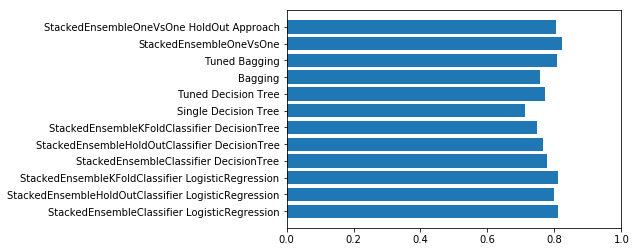

In [208]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.values()), align='center')
_= plt.yticks(range(len(model_valid_accuracy_comparisons)), list(model_valid_accuracy_comparisons.keys()))

<b>Accuracy on Test Data</b>

In [209]:
pd.DataFrame(list(model_test_accuracy_comparisons.items()), columns=['Model Name', 'Accuracy of Test Data'])

,Model Name,Accuracy of Test Data
0,StackedEnsembleClassifier LogisticRegression,0.804444
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.803333
2,StackedEnsembleKFoldClassifier LogisticRegression,0.797778
3,StackedEnsembleClassifier DecisionTree,0.775556
4,StackedEnsembleHoldOutClassifier DecisionTree,0.757778
5,StackedEnsembleKFoldClassifier DecisionTree,0.745556
6,Decision Tree,0.671111
7,Tuned Decision Tree,0.695556
8,Bagging,0.718889
9,Tuned Bagging,0.718889


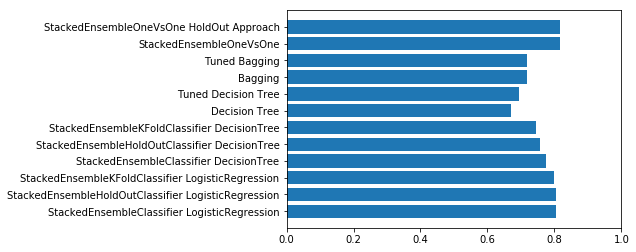

In [210]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

<b>Average F1 score on Validation Data</b>

In [211]:
pd.DataFrame(list(model_valid_f1_comparisons.items()), columns=['Model Name', 'Average F1 score of Validation Data'])

,Model Name,Average F1 score of Validation Data
0,StackedEnsembleClassifier LogisticRegression,0.81
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.80
2,StackedEnsembleKFoldClassifier LogisticRegression,0.81
3,StackedEnsembleClassifier DecisionTree,0.78
4,StackedEnsembleHoldOutClassifier DecisionTree,0.77
5,StackedEnsembleKFoldClassifier DecisionTree,0.74
6,Single Decision Tree,0.71
7,Tuned Decision Tree,0.78
8,Bagging,0.75
9,Tuned Bagging,0.80


<b>Average F1 score on Test Data</b>

In [212]:
pd.DataFrame(list(model_test_f1_comparisons.items()), columns=['Model Name', 'Average F1 score of Test Data'])

,Model Name,Average F1 score of Test Data
0,StackedEnsembleClassifier LogisticRegression,0.80
1,StackedEnsembleHoldOutClassifier LogisticRegre...,0.80
2,StackedEnsembleKFoldClassifier LogisticRegression,0.79
3,StackedEnsembleClassifier DecisionTree,0.78
4,StackedEnsembleHoldOutClassifier DecisionTree,0.76
5,StackedEnsembleKFoldClassifier DecisionTree,0.74
6,Decision Tree,0.66
7,Tuned Decision Tree,0.70
8,Bagging,0.70
9,Tuned Bagging,0.71


## Task 7 Reflect on the Performance of the Different Models Evaluated

*Write your reflection here (max 300 words)*

Accuracy and F1 score are used to evaluate the performance of different models. Higher the accuracy or F1 score, better the model. If we look at the above results, <b>StackedEnsembleOneVsOne</b> is giving us <b>highest accuracy</b> and <b>average F1 score</b> on test data than all other models. We are getting better accuracy as each classifier is trained to correctly predict two classes, which makes each base classifier a specialist. Also, it is <b>computationally less expensive</b> than other models as we are training the model only on the basis of two classes at a time. So this reduces the amount of training data, which is needed to train the base classifiers. To avoid over-fitting, I have used StackedEnsembleOneVsOne with Hold Out approach. With both the approaches, I am getting almost similar results. There is very little variation. Also we can see that stacked ensembles work better than single decision tree or even bagging. Using decision tree is computationally less expensive as it requires training a single model but we are not getting good accuracy by using that. So ensembles are better even though it’s computationally more expensive as we are training multiple models. Also we can see that there is no over-fitting happening in any of the stack ensembles as it is generalizing well on unseen data (test data). In terms of model complexity, it is less complex to understand a single decision tree than bagging or ensemble approach. But since we are not getting good accuracy, we have to consider ensembles. In ensembles, it is easy to understand StackedEnsembleClassifer than StackedEnsembleOneVsOne approach. In OneVsOne approach, we need to filter the data in order to train the binary base model. That's why it's little complicated. Otherwise, it's computationally less expensive than other models. So on the basis of above summary tables, we can say that StackedEnsembleOneVsOne is better than other models when trained and tested on 0.5% data. We can get better results once we train the model using more data.       